# Installation Setup

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
import pypfopt
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline 
%pylab inline
pylab.rcParams['figure.figsize'] = (20,10)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [33]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import StockPortfolioEnv

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [34]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [35]:
df_merged = pd.read_csv('data/merged.csv')
stock_dimension = len(df_merged.tic.unique())
df_merged

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,FNB,10629,2007-01-03,-0.732,3,XLF,18.340,0.007,-0.027,-0.050,-0.029,18.250,18.790,18.200,8.567,282800,2,0.000,8.741,8.698,100.000,66.667,100.000,8.567,8.567,0.000
1,FNB,10629,2007-01-04,0.167,3,XLF,18.460,-0.031,-0.023,-0.042,-0.036,18.330,18.500,18.080,8.623,168900,3,0.001,8.675,8.516,100.000,-66.667,100.000,8.595,8.595,0.000
2,FNB,10629,2007-01-05,0.852,3,XLF,17.880,0.010,0.008,-0.025,-0.018,17.980,18.350,17.850,8.353,170000,4,-0.007,8.801,8.228,16.666,-100.000,100.000,8.514,8.514,0.000
3,FNB,10629,2007-01-08,-0.037,3,XLF,18.050,-0.004,-0.020,-0.023,-0.014,17.840,18.150,17.600,8.432,204700,0,-0.007,8.742,8.246,33.476,-91.050,100.000,8.494,8.494,0.000
4,FNB,10629,2007-01-09,0.627,3,XLF,17.980,-0.007,-0.018,-0.010,-0.004,18.050,18.050,17.630,8.399,143600,1,-0.009,8.706,8.244,30.827,-79.596,100.000,8.475,8.475,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,JKHY,88664,2021-12-27,0.166,2,XLK,165.550,0.011,0.036,0.024,-0.040,165.960,165.960,163.460,163.312,233800,0,2.147,168.131,145.867,54.305,121.517,10.517,155.193,158.919,6.254
41543,JKHY,88664,2021-12-28,-0.055,2,XLK,167.380,0.003,0.043,0.014,-0.063,166.060,167.420,164.340,165.117,150600,1,2.349,168.917,146.614,55.947,130.005,15.690,155.526,158.967,1.498
41544,JKHY,88664,2021-12-29,-0.296,2,XLK,167.840,-0.001,0.030,0.024,-0.063,167.230,168.400,166.410,165.571,193100,2,2.516,169.478,147.699,56.354,132.184,19.048,155.898,159.052,1.988
41545,JKHY,88664,2021-12-30,-0.104,2,XLK,167.720,-0.004,0.011,0.003,-0.013,168.530,169.010,167.560,165.453,211800,3,2.609,168.982,150.189,56.214,125.298,21.137,156.246,159.141,2.014


# Weight Initialization
## Retail Weights (Rank-based method)

In [36]:
# Compute a set of weights for asset allocation
df_merged['moribvol'] = df_merged.groupby(['date'])['moribvol'].rank(method='first')
df_merged['moribvol'] = df_merged.groupby('date')['moribvol'].apply(lambda x: x/x.sum())

df_merged['fake_macd'] = np.random.normal(df_merged['macd'].mean(), df_merged['macd'].std(), size=len(df_merged['macd'])) 
df_merged['fake_rsi_30'] = np.random.normal(df_merged['rsi_30'].mean(), df_merged['cci_30'].std(), size=len(df_merged['dx_30'])) 
df_merged['fake_cci_30'] = np.random.normal(df_merged['cci_30'].mean(), df_merged['cci_30'].std(), size=len(df_merged['cci_30'])) 
df_merged['fake_dx_30'] = np.random.normal(df_merged['dx_30'].mean(), df_merged['dx_30'].std(), size=len(df_merged['dx_30'])) 

## Greedy Weights

In [37]:
df_merged['greedy'] = df_merged.groupby('date')['ret_1'].rank(method='first', ascending=False).apply(lambda x: 1 if x == 1 else 0)

## Equal Weights

In [38]:
df_merged['equal'] = 1/stock_dimension

## Mean-Variance Optimization Weights

In [39]:
def constrainedMV(cov_matrix):
    d = cov_matrix.shape[0]
    def objective(w, cov_matrix):
        return np.dot(w.T, np.dot(cov_matrix, w))
    initial_weight = np.abs(np.random.randn(d))
    x0 = np.ones(d) / d
    constraints = [{'type': 'eq', 'fun': lambda x:np.sum(x)-1}]
    result = minimize(lambda x:np.dot(x.T, np.dot(cov_matrix, x)), x0, constraints=constraints)
    a = np.array(result.x)
    return a

In [40]:
def rolling_windows(df,current_date,duration = 100):
    loc = df.index.get_loc(current_date)
    return df.iloc[loc - duration :loc + 1,:]

def prepare_df(df):
    used_df = df[['tic','date','ret_1']]
    df_pivot = used_df.pivot(index='date', columns='tic', values='ret_1').shift(1).iloc[1:,:]
    #use shift one because ret1 is the return on the next date.
    return df_pivot

def initialize_weight(df,rolling_length,short_sale = True):
    df = prepare_df(df)
    weight = pd.DataFrame(np.nan, index=df.index, columns=df.columns)
    d = len(df.iloc[0])
    for current_date in df.index:
        #if not sufficient data: return equal weight
        if df.index.get_loc(current_date) < rolling_length:
            weight.loc[current_date] = 1/len(df.iloc[0,:])
        #if sufficient data: return minimum variance portfolio weight
        else:
            cov = rolling_windows(df,current_date,rolling_length).cov().to_numpy()
            if short_sale == False:
                ef = pypfopt.EfficientFrontier(np.ones(d),cov)
                current_weight = list(ef.min_volatility().values())
                weight.loc[current_date] = current_weight
            else:
                cov_inv = np.linalg.inv(cov)
                date_weight = cov_inv @ np.ones(d)
                date_weight = date_weight / np.sum(date_weight)
                weight.loc[current_date] = date_weight
    return weight

mean_var_weight_df = initialize_weight(df_merged,100,False)
mean_var_weight_df.loc['2007-01-03'] = np.ones(11)/11
mean_var_weight_df = mean_var_weight_df.sort_index()

In [41]:
# Compute and append mean variance weights to "df_merged" here, say column name as "mean-var"
df_merged['mean-var'] = mean_var_weight_df.melt()['value']

## Data Split

In [42]:
START_DATE = '2007-01-03'
MID_DATE = '2018-01-02'
END_DATE = '2022-01-01'

tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
fake_tech_indicator_list = ['fake_macd', 'fake_rsi_30', 'fake_cci_30', 'fake_dx_30']
weights = ['moribvol', 'equal', 'greedy', 'mean-var']

states = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma']
states += fake_tech_indicator_list + weights

train_data = data_split(df_merged[states], START_DATE, MID_DATE)
trade_data = data_split(df_merged[states], MID_DATE, END_DATE)
full_data = data_split(df_merged[states], START_DATE, END_DATE)

In [43]:
train_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal,greedy,mean-var
0,2007-01-03,16.630,17.250,16.620,8.712,5540800,CNP,2,0.000,8.741,8.698,100.000,66.667,100.000,8.712,8.712,-1.485,-136.781,70.362,-0.272,0.061,0.091,0,0.091
0,2007-01-03,66.030,66.250,64.240,44.847,6297900,DVN,2,0.000,8.741,8.698,100.000,66.667,100.000,44.847,44.847,0.418,184.381,-0.403,1.417,0.091,0.091,0,0.091
0,2007-01-03,18.250,18.790,18.200,8.567,282800,FNB,2,0.000,8.741,8.698,100.000,66.667,100.000,8.567,8.567,-0.338,13.921,-8.875,30.901,0.015,0.091,0,0.091
0,2007-01-03,12.230,12.350,12.080,8.387,3313000,IPG,2,0.000,8.741,8.698,100.000,66.667,100.000,8.387,8.387,-0.750,92.651,-48.465,30.171,0.045,0.091,0,0.091
0,2007-01-03,21.530,21.890,21.160,17.301,565300,JKHY,2,0.000,8.741,8.698,100.000,66.667,100.000,17.301,17.301,-0.338,-244.724,170.517,38.534,0.167,0.091,0,0.091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,2017-12-29,35.890,35.890,35.400,32.854,133500,MLI,4,0.210,33.772,32.589,54.130,8.048,3.167,32.893,32.347,0.131,-35.275,167.986,28.155,0.015,0.091,0,0.000
2768,2017-12-29,49.490,49.760,49.280,45.486,1340300,SEE,4,0.797,46.025,43.477,63.352,103.275,34.896,43.983,42.412,-0.098,-135.890,5.702,50.685,0.076,0.091,0,0.128
2768,2017-12-29,32.341,32.607,32.119,30.584,102872,TR,4,0.039,31.573,30.107,49.152,-49.226,3.944,30.805,30.547,0.660,-87.299,-145.242,45.198,0.152,0.091,0,0.082
2768,2017-12-29,150.450,151.660,149.750,149.860,881900,VRTX,4,1.359,153.807,135.300,52.986,117.528,21.640,145.122,147.850,-0.019,167.509,-82.631,32.756,0.106,0.091,1,0.052


In [44]:
trade_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,fake_macd,fake_rsi_30,fake_cci_30,fake_dx_30,moribvol,equal,greedy,mean-var
0,2018-01-02,28.390,28.420,27.960,23.614,2553700,CNP,1,-0.236,24.715,23.268,42.923,-91.551,28.216,24.246,24.462,0.026,110.187,111.757,16.101,0.015,0.091,0,0.009
0,2018-01-02,41.790,42.250,41.640,33.284,4782500,DVN,1,0.883,34.038,28.087,62.616,157.303,40.030,30.626,29.926,-0.631,42.914,109.473,12.287,0.076,0.091,1,0.043
0,2018-01-02,13.870,14.040,13.710,11.064,2944100,FNB,1,0.060,11.536,10.919,51.265,-9.487,14.808,11.118,10.952,1.249,-51.879,-105.946,22.828,0.136,0.091,0,0.281
0,2018-01-02,19.320,20.260,19.150,16.428,5973800,IPG,1,0.147,16.717,16.238,51.956,-3.376,21.778,16.141,16.022,0.392,-28.415,-41.771,48.073,0.091,0.091,0,0.164
0,2018-01-02,117.320,117.480,115.480,109.610,273400,JKHY,1,0.916,111.912,108.500,60.261,22.145,9.589,109.258,105.793,1.668,116.199,42.254,26.674,0.152,0.091,0,0.035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,2021-12-31,59.160,59.590,58.690,58.141,158200,MLI,4,0.805,59.134,54.512,59.498,54.888,23.802,56.878,53.642,-0.034,-4.600,76.492,33.081,0.167,0.091,0,0.011
1007,2021-12-31,66.950,67.660,66.820,66.264,510600,SEE,4,1.101,67.080,61.021,59.940,156.421,23.167,63.532,61.330,1.408,62.981,9.277,17.229,0.152,0.091,0,0.000
1007,2021-12-31,34.188,34.329,33.764,33.733,100573,TR,4,0.761,36.910,31.927,56.292,21.555,3.458,32.928,31.338,0.821,177.711,61.511,-5.783,0.045,0.091,0,0.000
1007,2021-12-31,222.630,223.500,219.040,219.600,1142000,VRTX,4,7.364,228.355,199.916,65.058,90.909,46.178,205.856,195.491,0.294,26.861,59.315,21.180,0.136,0.091,0,0.176


In [45]:
# Last, save both train and trade dfs to csv in data foler
train_data.to_csv('data/train_data.csv', index=True)  
trade_data.to_csv('data/trade_data.csv', index=True)
full_data.to_csv('data/full_data.csv', index=True) 

# Benchmarks
We compare the performance of different weighting methods on the train period
 - Mean Variance
 - Equally weighted (Buy and hold)
 - Market indexes (NASDAQ and XLK)
 - Individual stocks

## Environment configuration
> A gym-style portfolio allocation environment for agents to interact. It is handy to compare the performances.

In [46]:
state_space = stock_dimension
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train_data, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade_data, **env_kwargs)
env = StockPortfolioEnv.StockPortfolioEnv(df = full_data, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


## Sampling
### Train-and-trade Separate

In [47]:
retail_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data['moribvol'])
retail_trade = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data['moribvol'])

begin_total_asset:1000000
end_total_asset:6403619.725722111
Sharpe:  0.8027240438671901
begin_total_asset:1000000
end_total_asset:2441370.1456132187
Sharpe:  1.0078092209505933


In [48]:
equal_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data['equal'])
equal_trade = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data['equal'])

begin_total_asset:1000000
end_total_asset:2833313.1867107362
Sharpe:  0.5083797149414689
begin_total_asset:1000000
end_total_asset:1797592.9698737739
Sharpe:  0.7072087263660661


In [49]:
greedy_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data['greedy'])
greedy_trade = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data['greedy'])

begin_total_asset:1000000
end_total_asset:2.7418573513396667e+38
Sharpe:  13.57562966686358
begin_total_asset:1000000
end_total_asset:2.829841679192863e+18
Sharpe:  15.908205172451844


In [50]:
mvo_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train_data['mean-var'])
mvo_trade = StockPortfolioEnv.sample_from_env(i=0, env=e_trade_gym, weights=trade_data['mean-var'])

begin_total_asset:1000000
end_total_asset:2050220.097747049
Sharpe:  0.3717533959301156
begin_total_asset:1000000
end_total_asset:1950163.492849117
Sharpe:  0.7366484254614866


### Full Data

In [51]:
retail = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=full_data['moribvol'])
retail_asset_memory = env.asset_memory

begin_total_asset:1000000
end_total_asset:15669715.94513573
Sharpe:  0.8588476452597806


In [52]:
equal = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=full_data['equal'])
equal_asset_memory = env.asset_memory

begin_total_asset:1000000
end_total_asset:5107204.831295201
Sharpe:  0.5632809975676928


In [53]:
greedy = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=full_data['greedy'])
greedy_asset_memory = env.asset_memory

begin_total_asset:1000000
end_total_asset:7.916936540105994e+50
Sharpe:  14.137667133470554


In [54]:
mvo = StockPortfolioEnv.sample_from_env(i=0, env=env, weights=full_data['mean-var'])
mvo_asset_memory = env.asset_memory

begin_total_asset:1000000
end_total_asset:4006471.6242536153
Sharpe:  0.46841399831768143


## Performance Comparison
### Plotting

In [55]:
# XLK
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

yf_xlk = YahooDownloader(start_date = START_DATE, end_date = END_DATE, ticker_list = ["XLK"]).fetch_data()
yf_xlk = fe.preprocess_data(yf_xlk)
yf_xlk['ret'] = yf_xlk['open'] / yf_xlk['open'].loc[0]
yf_xlk = yf_xlk.fillna(0)
yf_xlk = yf_xlk.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3777, 8)
Successfully added technical indicators
Successfully added turbulence index


In [56]:
# SPY
yf_spy = YahooDownloader(start_date = START_DATE, end_date = END_DATE, ticker_list = ["SPY"]).fetch_data()
yf_spy = fe.preprocess_data(yf_spy)
yf_spy['ret'] = yf_spy['open'] / yf_spy['open'].loc[0]
yf_spy = yf_spy.fillna(0)
yf_spy = yf_spy.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3777, 8)
Successfully added technical indicators
Successfully added turbulence index


In [57]:
# individual stocks
grouped = df_merged.groupby('tic')
selected_cum_ret = grouped.apply(lambda x: x['open']/x['open'].iloc[0])
selected_cum_ret = selected_cum_ret.reset_index()
selected_cum_ret = selected_cum_ret.set_index('level_1')
selected_cum_ret = selected_cum_ret.join(df_merged[['date']])

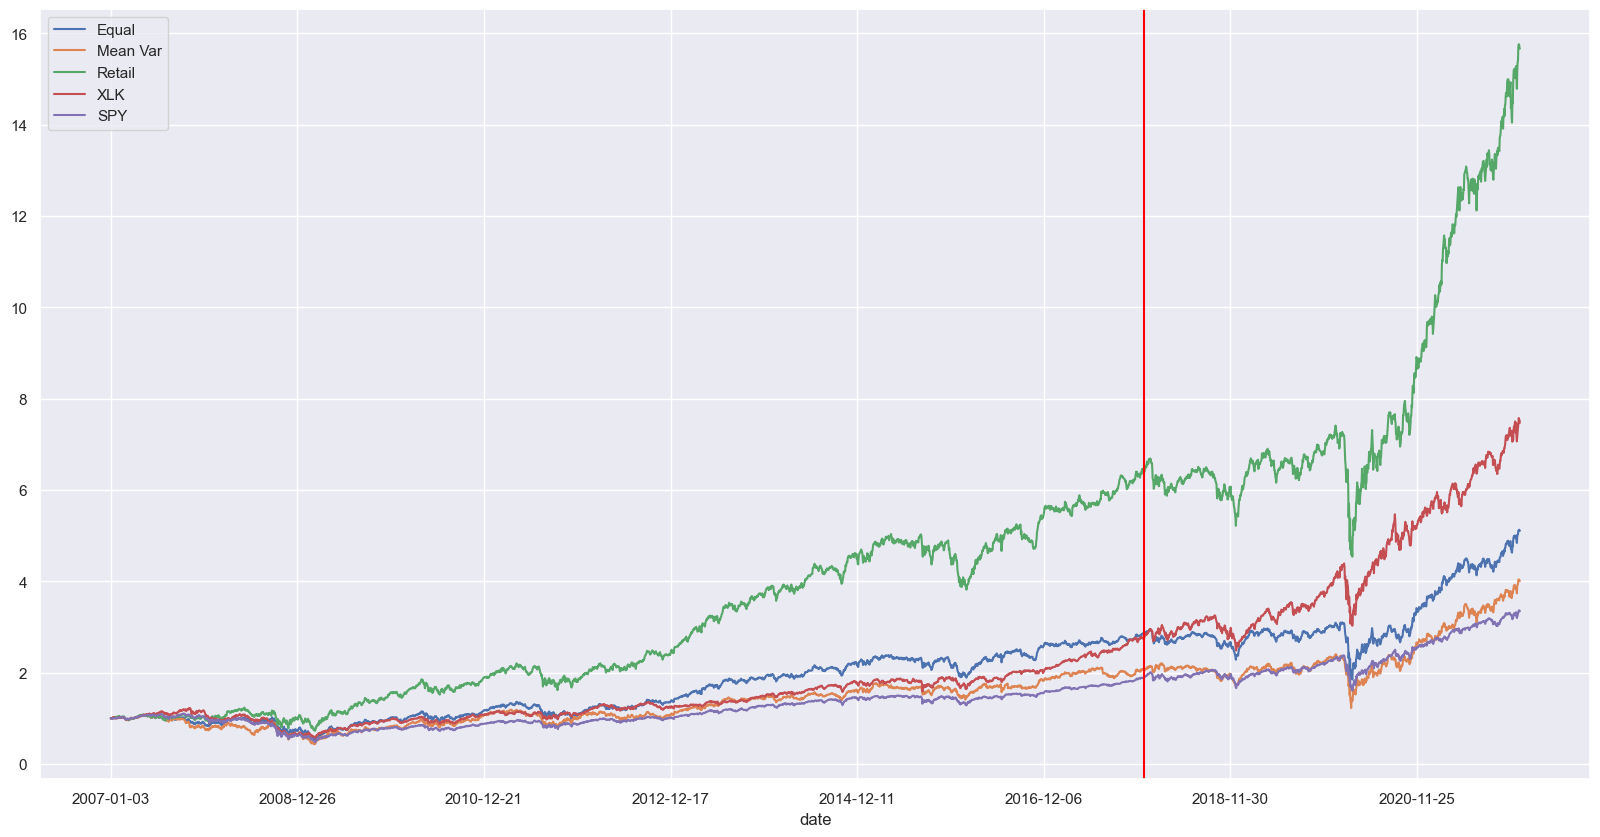

In [58]:
fig, ax = plt.subplots()
dates = full_data['date'].unique()

# Equal
equal_cum_ret = pd.DataFrame({'date': dates, 'ret': equal_asset_memory}) 
equal_cum_ret['ret'] = equal_cum_ret['ret'] / equal_cum_ret['ret'].loc[0]
ax = equal_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Equal")

# Mean Variance
mvo_cum_ret = pd.DataFrame({'date': dates, 'ret': mvo_asset_memory}) 
mvo_cum_ret['ret'] = mvo_cum_ret['ret'] / mvo_cum_ret['ret'].loc[0]
ax = mvo_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Mean Var")

# Retail
retail_cum_ret = pd.DataFrame({'date': dates, 'ret': retail_asset_memory}) 
retail_cum_ret['ret'] = retail_cum_ret['ret'] / retail_cum_ret['ret'].loc[0]
ax = retail_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Retail")

# # Greedy
# greedy_cum_ret = pd.DataFrame({'date': dates, 'ret': greedy_asset_memory}) 
# greedy_cum_ret['ret'] = greedy_cum_ret['ret'] / greedy_cum_ret['ret'].loc[0]
# ax = greedy_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Greedy")

# XLK
ax = yf_xlk.plot(ax=ax, kind='line', x='date', y='ret', label="XLK")

# SPY
ax = yf_spy.plot(ax=ax, kind='line', x='date', y='ret', label="SPY")

ax.axvline(x=np.where(dates == MID_DATE)[0][0], color = 'red')
plt.show()

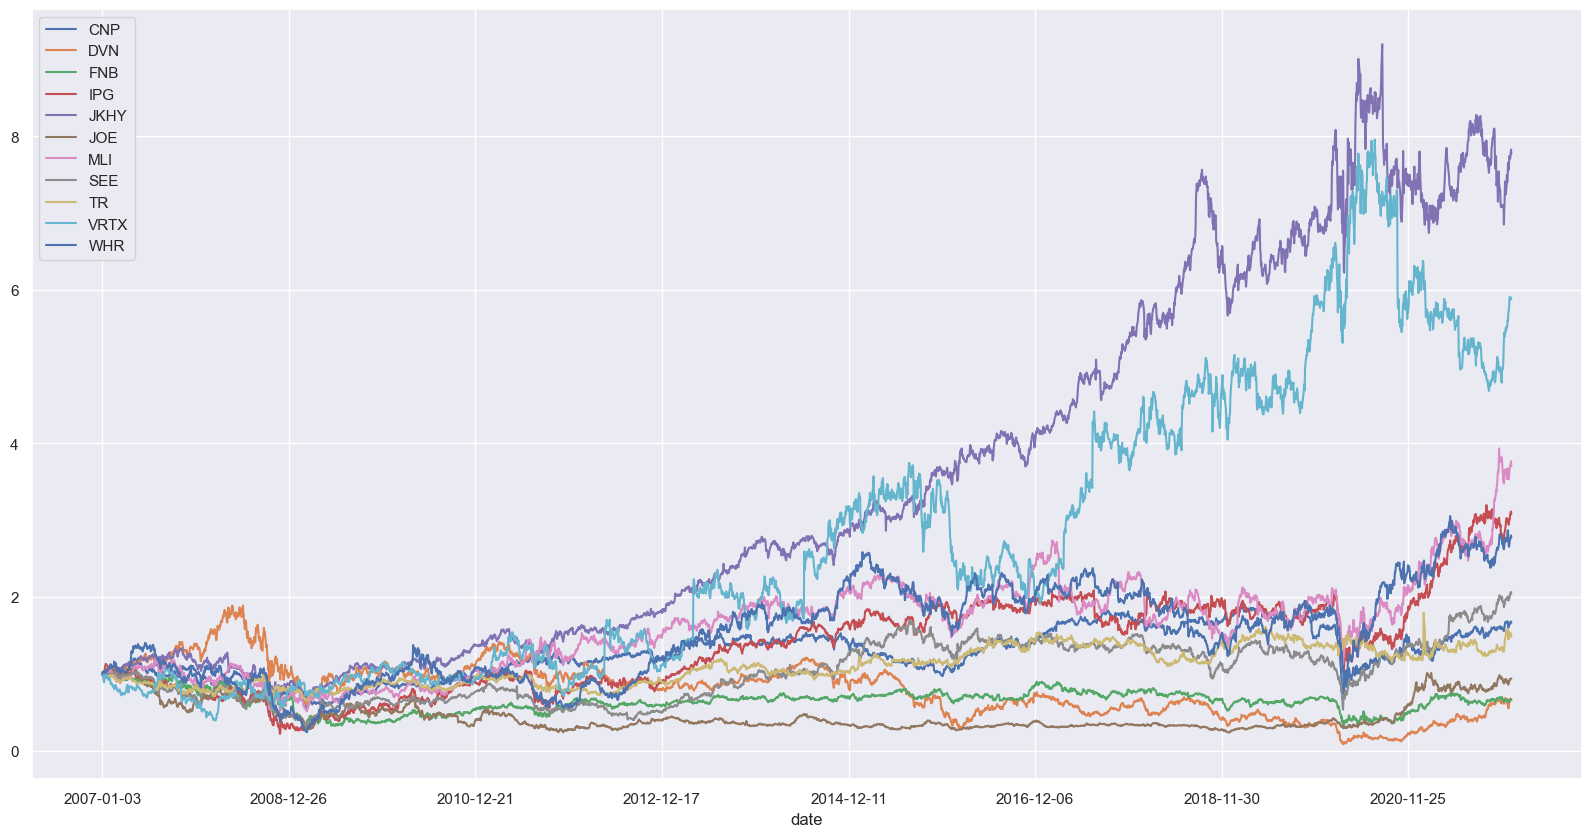

In [59]:
fig, ax = plt.subplots()

# 个股
for key, grp in selected_cum_ret.groupby(['tic']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='open', label=key)
    
plt.show()

### Backtesting

In [60]:
def backtest_helper(ret):
    df = ret.copy()
    df['account_value'] = df['ret']
    perf_stats_all = backtest_stats(df)

In [61]:
backtest_helper(retail_cum_ret)

Annual return          0.202
Cumulative returns    14.670
Annual volatility      0.250
Sharpe ratio           0.859
Calmar ratio           0.490
Stability              0.955
Max drawdown          -0.411
Omega ratio            1.175
Sortino ratio          1.260
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.003
Daily value at risk   -0.031
dtype: float64


In [62]:
backtest_helper(equal_cum_ret)

Annual return          0.115
Cumulative returns     4.107
Annual volatility      0.248
Sharpe ratio           0.563
Calmar ratio           0.226
Stability              0.916
Max drawdown          -0.509
Omega ratio            1.113
Sortino ratio          0.808
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.980
Daily value at risk   -0.031
dtype: float64


In [63]:
backtest_helper(mvo_cum_ret)

Annual return          0.097
Cumulative returns     3.006
Annual volatility      0.284
Sharpe ratio           0.468
Calmar ratio           0.162
Stability              0.877
Max drawdown          -0.600
Omega ratio            1.093
Sortino ratio          0.676
Skew                     NaN
Kurtosis                 NaN
Tail ratio             1.016
Daily value at risk   -0.035
dtype: float64


In [64]:
backtest_helper(yf_spy)

Annual return          0.084
Cumulative returns     2.344
Annual volatility      0.194
Sharpe ratio           0.513
Calmar ratio           0.148
Stability              0.857
Max drawdown          -0.567
Omega ratio            1.105
Sortino ratio          0.710
Skew                     NaN
Kurtosis                 NaN
Tail ratio             0.899
Daily value at risk   -0.024
dtype: float64
